In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv


In [1]:
# =============================================================================
# TABNET DEEP LEARNING - EARTHQUAKE MAGNITUDE PREDICTION
# Running on Kaggle Environment
# =============================================================================

# =============================================================================
# 0. INSTALL & IMPORT LIBRARIES
# =============================================================================
print("📦 Installing pytorch-tabnet...")
!pip install pytorch-tabnet -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    median_absolute_error,
    max_error,
    mean_absolute_percentage_error
)
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

# =============================================================================
# 1. CONFIGURATION & DATA LOADING
# =============================================================================
print("\n" + "="*80)
print(" TABNET DEEP LEARNING - EARTHQUAKE MAGNITUDE PREDICTION")
print(" Running on Kaggle Environment")
print("="*80)

FILE_PATH = "/kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv"

print("\n📂 STEP 1: Loading Data from Kaggle...")
df = pd.read_csv(FILE_PATH)
print("✅ Data loaded successfully!")
print(f"   Initial shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")

# Time processing for filtering
if 'year' not in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df['year'] = df['Timestamp'].dt.year

# Filter data by year - CHỈ LẤY 1 NĂM
max_year = df['year'].max()
cutoff_year = max_year 
print(f"   Using data from year {cutoff_year} to {max_year}")

df = df[df['year'] >= cutoff_year]. copy()
print(f"   Rows after year filter: {len(df):,}")

# =============================================================================
# 2. DATA CLEANING
# =============================================================================
print("\n🧹 STEP 2: Data Preprocessing...")

cols_to_drop = [
    'energy', 'magnitude_category', 'depth_category',
    'id', 'updated', 'place', 'status', 'Timestamp', 
    'year', 'month', 'day', 'mag'
]

existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols_to_drop, errors='ignore')

# =============================================================================
# 3. FEATURE SELECTION
# =============================================================================
print("\n🎯 STEP 3: Feature Selection...")

potential_features = ['Latitude', 'Longitude', 'Depth', 'gap', 'nst']
target_col = 'Magnitude'

available_features = [f for f in potential_features if f in df_clean.columns]

if target_col not in df_clean.columns:
    raise ValueError(f"Target column '{target_col}' not found in data!")

print(f"   ✅ All required columns found!")
print(f"   Features:  {available_features}")
print(f"   Target:  {target_col}")

df_model = df_clean[available_features + [target_col]].dropna()
print(f"\n   Removed {len(df_clean) - len(df_model)} rows with missing values")
print(f"   Final dataset: {len(df_model):,} rows")

X = df_model[available_features]
y = df_model[target_col]

print(f"\n   Data Statistics:")
print(df_model.describe())

# =============================================================================
# 4. OUTLIER REMOVAL
# =============================================================================
print(f"\n   After removing outliers...")

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

mask = (y >= (Q1 - 1.5 * IQR)) & (y <= (Q3 + 1.5 * IQR))
X = X[mask]
y = y[mask]

print(f"   After removing outliers:  {len(X):,} rows")
print(f"\n   Final X shape: {X.shape}")
print(f"   Final y shape: {y.shape}")

# =============================================================================
# 5. TRAIN/TEST SPLIT
# =============================================================================
print(f"\n✂️ STEP 4: Train/Test Split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Train set: {len(X_train):,} samples (80. 0%)")
print(f"   Test set: {len(X_test):,} samples (20.0%)")

# =============================================================================
# 6. TABNET MODEL CONFIGURATION
# =============================================================================
print(f"\n🤖 STEP 5: Configuring TabNet Deep Learning Model...")

import torch
device = 'cuda' if torch.cuda. is_available() else 'cpu'
print(f"   Device: {device. upper()}")

print(f"\n   Architecture Configuration:")
print(f"     - Decision dimension (n_d): 64")
print(f"     - Attention dimension (n_a): 64")
print(f"     - Sequential steps: 5")
print(f"     - Independent layers: 2")
print(f"     - Shared layers: 2")
print(f"     - Sparsity regularization: 0.001")

model = TabNetRegressor(
    n_d=64,
    n_a=64,
    n_steps=5,
    n_independent=2,
    n_shared=2,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_params=dict(lr=0.02),
    scheduler_params={"step_size": 20, "gamma": 0.9},
    mask_type="sparsemax",
    verbose=1,
    seed=42
)

print(f"\n   ✅ TabNet model initialized!")

# =============================================================================
# 7. MODEL TRAINING
# =============================================================================
print(f"\n🚀 STEP 6: Training TabNet Model...")
print(f"   This is DEEP LEARNING with:")
print(f"     - Neural network layers with attention")
print(f"     - Backpropagation & gradient descent")
print(f"     - Batch training with Adam optimizer")
print(f"     - Learning rate scheduling")

print(f"\n   Training Configuration:")
print(f"     - Max epochs: 50")
print(f"     - Patience (early stopping): 10")
print(f"     - Batch size: 2048")
print(f"     - Virtual batch size: 256")
print(f"\n")

model.fit(
    X_train. values, y_train. values. reshape(-1, 1),
    eval_set=[(X_test. values, y_test.values. reshape(-1, 1))],
    eval_metric=['rmse', 'mae'],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=256
)

print(f"\n✅ Training completed!")

# =============================================================================
# 8. MODEL EVALUATION
# =============================================================================
print(f"\n📈 STEP 7: Model Evaluation...")

y_pred = model.predict(X_test.values)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n" + "="*80)
print(" 🏆 TABNET DEEP LEARNING - FINAL RESULTS")
print("="*80)
print(f"   RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"   MAE (Mean Absolute Error):      {mae:.4f}")
print(f"   MedAE (Median Absolute Error):  {medae:.4f}")
print(f"   Max Error:                      {max_err:.4f}")
print(f"   MAPE (Mean Absolute % Error):   {mape:.2f}%")
print(f"   R² Score:                       {r2:.4f}")
print("="*80)

if r2 > 0.9:
    print(f"\n   🎉 EXCELLENT!  R² > 0.9 - Model explains 90%+ of variance")
elif r2 > 0.7:
    print(f"\n   👍 GOOD! R² > 0.7 - Model explains 70%+ of variance")
else:
    print(f"\n   ⚠️ Model needs improvement")

# =============================================================================
# 9. FEATURE IMPORTANCE
# =============================================================================
print(f"\n🔍 STEP 8: Feature Importance Analysis...")
print(f"   (Learned by Deep Learning Attention Mechanism)\n")

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(f"   Feature Importance Scores:\n")
for idx, row in importance_df.iterrows():
    bar = '█' * int(row['Importance'] * 50)
    print(f"   {row['Feature']: 15s} │ {bar} {row['Importance']:.4f}")

# =============================================================================
# 10. VISUALIZATION
# =============================================================================
print(f"\n📊 STEP 9: Creating Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Magnitude', fontsize=12)
axes[0, 0].set_ylabel('Predicted Magnitude', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted (R²={r2:.4f})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_test. values - y_pred. flatten()
axes[0, 1].scatter(y_pred, residuals, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1]. set_xlabel('Predicted Magnitude', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[1, 0]. hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0]. set_xlabel('Prediction Error', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title(f'Error Distribution (MAE={mae:.4f})', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
axes[1, 1].barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
axes[1, 1].set_xlabel('Importance Score', fontsize=12)
axes[1, 1].set_title('Feature Importance (TabNet Attention)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('tabnet_results.png', dpi=300, bbox_inches='tight')
print("   ✅ Visualization saved as 'tabnet_results.png'")
plt.show()

# =============================================================================
# 11. SAVE MODEL
# =============================================================================
print(f"\n💾 STEP 10: Saving Model...")
model.save_model("tabnet_earthquake_model.zip")
print(f"   ✅ Model saved to:  tabnet_earthquake_model.zip")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*80)
print(" ✅ TRAINING COMPLETE!")
print("="*80)
print(f" Model:       TabNet Deep Learning Regressor")
print(f" Features:   {len(available_features)} ({', '.join(available_features)})")
print(f" Training:    {len(X_train):,} samples")
print(f" Testing:    {len(X_test):,} samples")
print(f" Best R²:    {r2:.4f}")
print(f" Final MAE:  {mae:.4f}")
print(f" Final RMSE: {rmse:.4f}")
print("="*80)
print("\n🎉 All done!")

📦 Installing pytorch-tabnet...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00
✅ Libraries imported successfully!

 TABNET DEEP LEARNING - EARTHQUAKE MAGNITUDE PREDICTION
 Running on Kaggle Environment

📂 STEP 1: Loading Data from Kaggle...
✅ Data loaded successfully!
   Initial shape: (2921770, 28)
   Columns: ['Timestamp', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'magType', 'nst', 'gap', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'status', 'locationSource', 'magSource', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'energy', 'magnitude_category', 'depth_category']
   Using data from year 2025 to 2025
   Rows after year filter: 121,958

🧹 STEP 2: Data Preprocessing...

🎯 STEP 3: Feature Selection...
   ✅ All required columns found!
   Features:  ['Latitude', 'Longitude', 'Depth', 'gap', 'nst']
   Target:  Magnitude

   Removed 6 rows with missing values
   Final dataset: 121,952 rows

   Data Statist

ValueError: Space not allowed in string format specifier

Initial dataset shape: (2921770, 28)
Filtered dataset shape (latest year only): (121958, 28)
Max year kept: 2025
Modeling dataset shape (after dropna): (121952, 6)


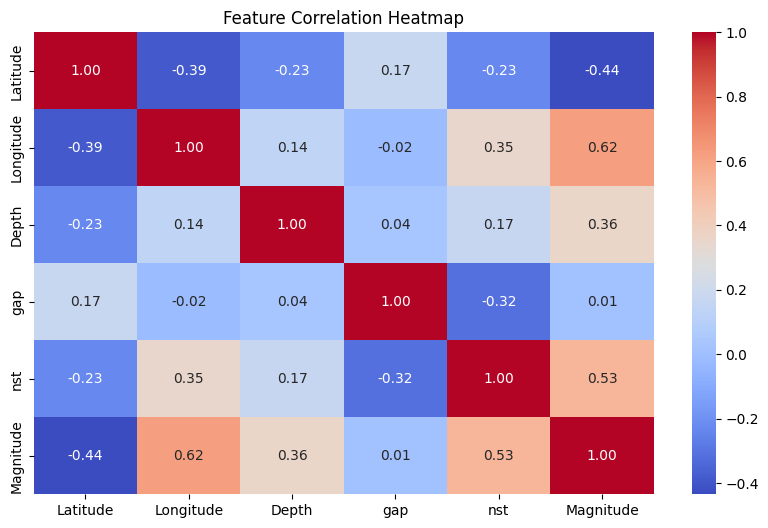


Selected features by RFE: ['Latitude', 'Longitude', 'Depth', 'nst']
Feature ranking (1 is best):
  Latitude: 1
  Longitude: 1
  Depth: 1
  gap: 2
  nst: 1

Training: TabNet
epoch 0  | loss: 1.83742 | val_0_rmse: 1.46037 |  0:00:06s
epoch 1  | loss: 0.60016 | val_0_rmse: 0.97272 |  0:00:14s
epoch 2  | loss: 0.42302 | val_0_rmse: 0.72263 |  0:00:21s
epoch 3  | loss: 0.38001 | val_0_rmse: 0.58586 |  0:00:28s
epoch 4  | loss: 0.35372 | val_0_rmse: 0.63755 |  0:00:35s
epoch 5  | loss: 0.33779 | val_0_rmse: 0.59596 |  0:00:42s
epoch 6  | loss: 0.32795 | val_0_rmse: 0.56369 |  0:00:49s
epoch 7  | loss: 0.31892 | val_0_rmse: 0.5559  |  0:00:56s
epoch 8  | loss: 0.30901 | val_0_rmse: 0.53533 |  0:01:04s
epoch 9  | loss: 0.29704 | val_0_rmse: 0.52552 |  0:01:11s
epoch 10 | loss: 0.29213 | val_0_rmse: 0.51748 |  0:01:18s
epoch 11 | loss: 0.28482 | val_0_rmse: 0.51741 |  0:01:25s
epoch 12 | loss: 0.28451 | val_0_rmse: 0.5198  |  0:01:32s
epoch 13 | loss: 0.27775 | val_0_rmse: 0.512   |  0:01:39s


KeyboardInterrupt: 

In [2]:
# =========================
# Kaggle Notebook - TabNet Regression (keep same logic, swap models -> TabNet)
# Data path: /kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv
# =========================

# --- Install TabNet if missing ---
import sys, subprocess

def _pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

try:
    from pytorch_tabnet.tab_model import TabNetRegressor
except Exception:
    _pip_install("pytorch-tabnet")
    from pytorch_tabnet.tab_model import TabNetRegressor

# --- Imports (same stack as original) ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    r2_score
)

import torch

# =========================
# 1) Load data (Kaggle path)
# =========================
DATA_PATH = "/kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv"
df = pd.read_csv(DATA_PATH)
print("Initial dataset shape:", df.shape)

# ==========================================
# 2) Time processing -> keep ONLY latest year
# ==========================================
# Create 'year' from 'Timestamp' if not present
if "year" not in df.columns:
    if "Timestamp" in df.columns:
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
        df["year"] = df["Timestamp"].dt.year
    else:
        raise ValueError("No 'year' column and no 'Timestamp' column found to derive year.")

max_year = df["year"].max()
cutoff_year = max_year  # keep original logic (ONLY latest year)
df = df[df["year"] >= cutoff_year].copy()
print("Filtered dataset shape (latest year only):", df.shape)
print("Max year kept:", max_year)

# =========================
# 3) Data cleaning
# =========================
cols_to_drop = [
    "energy", "magnitude_category", "depth_category",
    "id", "updated", "place", "status",
    "Timestamp", "year", "month", "day", "mag"
]
df_clean = df.drop(columns=cols_to_drop, errors="ignore").copy()

# Features + target (keep same candidates)
available_features = ["Latitude", "Longitude", "Depth", "gap", "nst"]
target_col = "Magnitude"

# Keep only features that exist (prevents crash if a column is missing)
existing_features = [c for c in available_features if c in df_clean.columns]
missing_features = [c for c in available_features if c not in df_clean.columns]
if missing_features:
    print("WARNING: Missing features in CSV:", missing_features)

if target_col not in df_clean.columns:
    raise ValueError(f"Target column '{target_col}' not found in data.")

df_model = df_clean[existing_features + [target_col]].dropna().copy()
print("Modeling dataset shape (after dropna):", df_model.shape)

X = df_model[existing_features]
y = df_model[target_col]

# =========================
# 4) Correlation heatmap
# =========================
plt.figure(figsize=(10, 6))
sns.heatmap(df_model.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# =========================
# 5) Feature selection (RFE)
# =========================
# Keep original RFE logic (even though final model is TabNet)
n_select = min(4, len(existing_features))  # original requested 4, but guard if fewer features exist
rf_est = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

rfe = RFE(estimator=rf_est, n_features_to_select=n_select)
rfe.fit(X, y)

selected_features = [f for f, keep in zip(existing_features, rfe.support_) if keep]
feature_ranking = dict(zip(existing_features, rfe.ranking_))

print("\nSelected features by RFE:", selected_features)
print("Feature ranking (1 is best):")
for k, v in feature_ranking.items():
    print(f"  {k}: {v}")

# =========================
# 6) Train/test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values,
    test_size=0.2,
    random_state=42
)

# =========================
# 7) Advanced evaluation
# =========================
def evaluate_model_advanced(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    medae = float(median_absolute_error(y_true, y_pred))
    maxerr = float(max_error(y_true, y_pred))

    eps = 1e-9
    mape = float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0)

    r2 = float(r2_score(y_true, y_pred))
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MedAE": medae,
        "MaxError": maxerr,
        "MAPE(%)": mape,
        "R2": r2
    }

# ==========================================
# 8) TabNet model (swap all experiments -> TabNet)
# ==========================================
class TabNetSklearnWrapper:
    """
    Wrapper to keep the same "models dict + loop" logic:
      model.fit(X_train, y_train)
      model.predict(X_test)
    """
    def __init__(
        self,
        seed=42,
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        tabnet_params=None
    ):
        self.seed = seed
        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.num_workers = num_workers

        if tabnet_params is None:
            tabnet_params = {}

        device_name = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = TabNetRegressor(
            seed=self.seed,
            device_name=device_name,
            **tabnet_params
        )

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        # Internal split for early stopping (keeps outer train/test split unchanged)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.1, random_state=self.seed
        )

        self.model.fit(
            X_train=X_tr,
            y_train=y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric=["rmse"],
            max_epochs=self.max_epochs,
            patience=self.patience,
            batch_size=self.batch_size,
            virtual_batch_size=self.virtual_batch_size,
            num_workers=self.num_workers,
            drop_last=False
        )
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        pred = self.model.predict(X)
        return pred.reshape(-1)

# TabNet hyperparams (reasonable defaults for small tabular regression)
tabnet_hparams = dict(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-4),
    mask_type="entmax"
)

models = {
    "TabNet": TabNetSklearnWrapper(
        seed=42,
        max_epochs=300,
        patience=30,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        tabnet_params=tabnet_hparams
    )
}

# =========================
# 9) Train + evaluate loop
# =========================
results = []
for model_name, model in models.items():
    print(f"\nTraining: {model_name}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = evaluate_model_advanced(y_test, y_pred)

    results.append({
        "Model": model_name,
        **metrics
    })

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print("\n=== Model Performance Ranking (sorted by RMSE) ===")
print(results_df)

# =========================
# 10) Visualization (same style as original)
# =========================
# Barplot for RMSE/MAE/MedAE
plt.figure(figsize=(12, 6))
plot_df = results_df.melt(
    id_vars=["Model"],
    value_vars=["RMSE", "MAE", "MedAE"],
    var_name="Metric",
    value_name="Value"
)
sns.barplot(data=plot_df, x="Model", y="Value", hue="Metric")
plt.title("Model Comparison (Lower is Better): RMSE, MAE, MedAE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Barplot for R2
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="R2")
plt.title("Model Comparison (Higher is Better): R²")
plt.xticks(rotation=15)
plt.ylim(0, 1)  # keep original behavior (may hide negative R2)
plt.tight_layout()
plt.show()


Initial dataset shape: (2921770, 28)
Filtered dataset shape (latest year only): (121958, 28)
Max year kept: 2025
Modeling dataset shape (after dropna): (121952, 6)


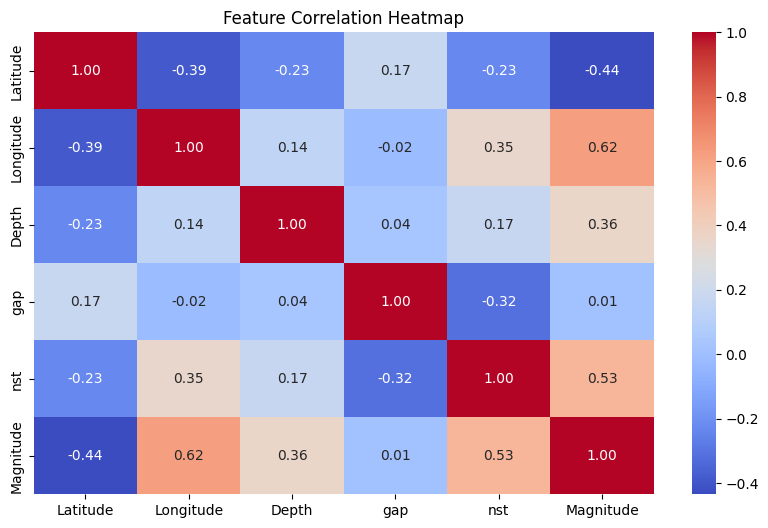


Selected features by RFE: ['Latitude', 'Longitude', 'Depth', 'nst']
Feature ranking (1 is best):
  Latitude: 1
  Longitude: 1
  Depth: 1
  gap: 2
  nst: 1

Baseline (predict mean) metrics: {'RMSE': 1.4078619770489158, 'MAE': 1.074002390831904, 'MedAE': 0.8104931456431314, 'MaxError': 7.08950685435687, 'MAPE(%)': 245448376.38471878, 'R2': -2.415423061408184e-05}

Training: TabNet


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60309 | val_0_rmse: 0.5771  |  0:00:02s
epoch 1  | loss: 0.35236 | val_0_rmse: 0.55376 |  0:00:04s
epoch 2  | loss: 0.32165 | val_0_rmse: 0.5399  |  0:00:07s
epoch 3  | loss: 0.30611 | val_0_rmse: 0.53121 |  0:00:09s
epoch 4  | loss: 0.29804 | val_0_rmse: 0.51977 |  0:00:11s
epoch 5  | loss: 0.28883 | val_0_rmse: 0.51901 |  0:00:13s
epoch 6  | loss: 0.283   | val_0_rmse: 0.50992 |  0:00:16s
epoch 7  | loss: 0.27559 | val_0_rmse: 0.49924 |  0:00:18s
epoch 8  | loss: 0.27268 | val_0_rmse: 0.49532 |  0:00:20s
epoch 9  | loss: 0.26833 | val_0_rmse: 0.49957 |  0:00:23s
epoch 10 | loss: 0.26434 | val_0_rmse: 0.49605 |  0:00:25s
epoch 11 | loss: 0.25899 | val_0_rmse: 0.49658 |  0:00:27s
epoch 12 | loss: 0.25941 | val_0_rmse: 0.49795 |  0:00:30s
epoch 13 | loss: 0.25711 | val_0_rmse: 0.48806 |  0:00:32s
epoch 14 | loss: 0.25539 | val_0_rmse: 0.48701 |  0:00:34s
epoch 15 | loss: 0.25181 | val_0_rmse: 0.49448 |  0:00:36s
epoch 16 | loss: 0.24962 | val_0_rmse: 0.50439 |  0:00:3

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== Model Performance Ranking (sorted by RMSE) ===
    Model      RMSE       MAE     MedAE  MaxError       MAPE(%)        R2
0  TabNet  0.383485  0.279427  0.212427  3.526516  6.106880e+07  0.925803


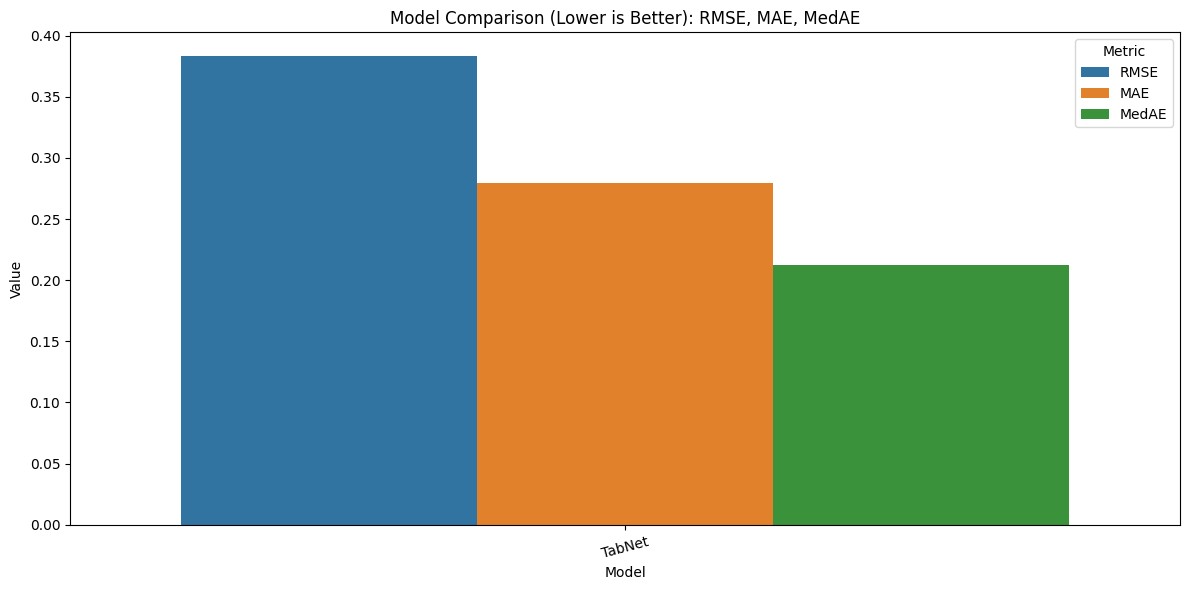

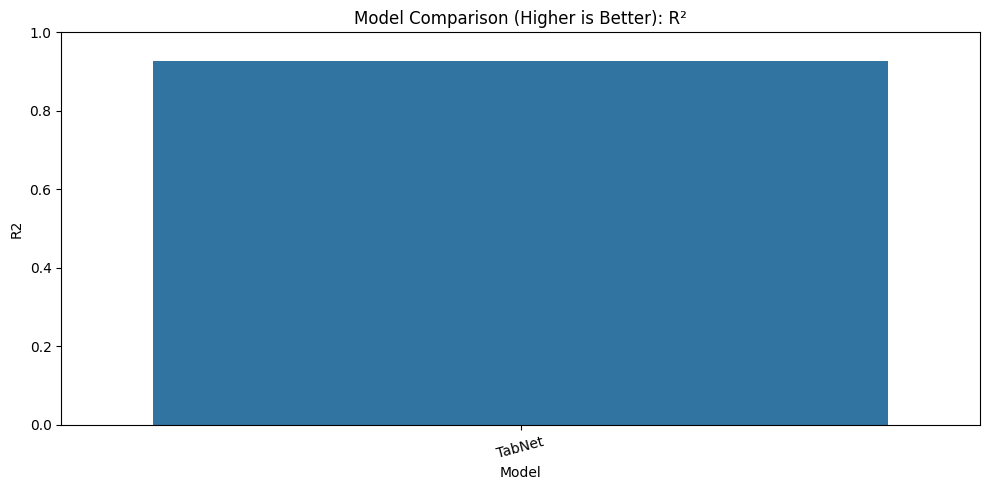

In [8]:
# =========================
# Kaggle Notebook - TabNet Regression (same logic, improved TabNet)
# Data path: /kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv
# =========================

# --- Install TabNet if missing ---
import sys, subprocess
def _pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

try:
    from pytorch_tabnet.tab_model import TabNetRegressor
except Exception:
    _pip_install("pytorch-tabnet")
    from pytorch_tabnet.tab_model import TabNetRegressor

# --- Imports (same stack) ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    r2_score
)

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# =========================
# 1) Load data (Kaggle path)
# =========================
DATA_PATH = "/kaggle/input/nmkhoi/final_earthquake_data_2002_2025.csv"
df = pd.read_csv(DATA_PATH)
print("Initial dataset shape:", df.shape)

# ==========================================
# 2) Time processing -> keep ONLY latest year
# ==========================================
if "year" not in df.columns:
    if "Timestamp" in df.columns:
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
        df["year"] = df["Timestamp"].dt.year
    else:
        raise ValueError("No 'year' column and no 'Timestamp' column found to derive year.")

max_year = df["year"].max()
cutoff_year = max_year
df = df[df["year"] >= cutoff_year].copy()
print("Filtered dataset shape (latest year only):", df.shape)
print("Max year kept:", max_year)

# =========================
# 3) Data cleaning
# =========================
cols_to_drop = [
    "energy", "magnitude_category", "depth_category",
    "id", "updated", "place", "status",
    "Timestamp", "year", "month", "day", "mag"
]
df_clean = df.drop(columns=cols_to_drop, errors="ignore").copy()

available_features = ["Latitude", "Longitude", "Depth", "gap", "nst"]
target_col = "Magnitude"

existing_features = [c for c in available_features if c in df_clean.columns]
missing_features = [c for c in available_features if c not in df_clean.columns]
if missing_features:
    print("WARNING: Missing features in CSV:", missing_features)

if target_col not in df_clean.columns:
    raise ValueError(f"Target column '{target_col}' not found in data.")

df_model = df_clean[existing_features + [target_col]].dropna().copy()
print("Modeling dataset shape (after dropna):", df_model.shape)

X = df_model[existing_features]
y = df_model[target_col]

# =========================
# 4) Correlation heatmap
# =========================
plt.figure(figsize=(10, 6))
sns.heatmap(df_model.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# =========================
# 5) Feature selection (RFE) - kept as original analysis step
# =========================
n_select = min(4, len(existing_features))
rf_est = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

rfe = RFE(estimator=rf_est, n_features_to_select=n_select)
rfe.fit(X, y)

selected_features = [f for f, keep in zip(existing_features, rfe.support_) if keep]
feature_ranking = dict(zip(existing_features, rfe.ranking_))

print("\nSelected features by RFE:", selected_features)
print("Feature ranking (1 is best):")
for k, v in feature_ranking.items():
    print(f"  {k}: {v}")

# =========================
# 6) Train/test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values,
    test_size=0.2,
    random_state=42
)

# =========================
# 7) Advanced evaluation
# =========================
def evaluate_model_advanced(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    medae = float(median_absolute_error(y_true, y_pred))
    maxerr = float(max_error(y_true, y_pred))

    eps = 1e-9
    mape = float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0)

    r2 = float(r2_score(y_true, y_pred))
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MedAE": medae,
        "MaxError": maxerr,
        "MAPE(%)": mape,
        "R2": r2
    }

# Baseline (mean predictor) - quick sanity
y_base = np.full_like(y_test, fill_value=np.mean(y_train), dtype=np.float64)
print("\nBaseline (predict mean) metrics:", evaluate_model_advanced(y_test, y_base))

# ==========================================
# 8) TabNet model (improved: smaller + scaler + scheduler)
# ==========================================
class TabNetSklearnWrapper:
    """
    Keeps same loop logic:
      model.fit(X_train, y_train)
      model.predict(X_test)
    Adds:
      - StandardScaler fit on train only
      - Smaller TabNet capacity (for tiny feature sets)
      - ReduceLROnPlateau scheduler
      - Gradient clipping
    """
    def __init__(
        self,
        seed=42,
        max_epochs=800,
        patience=80,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        use_scaler=True,
        tabnet_params=None
    ):
        self.seed = seed
        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.num_workers = num_workers
        self.use_scaler = use_scaler
        self.scaler = StandardScaler() if use_scaler else None

        if tabnet_params is None:
            tabnet_params = {}

        device_name = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = TabNetRegressor(
            seed=self.seed,
            device_name=device_name,
            **tabnet_params
        )

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        # Internal val split for early stopping (no test leakage)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.seed
        )

        if self.use_scaler:
            self.scaler.fit(X_tr)
            X_tr = self.scaler.transform(X_tr).astype(np.float32)
            X_val = self.scaler.transform(X_val).astype(np.float32)

        self.model.fit(
            X_train=X_tr,
            y_train=y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric=["rmse"],
            max_epochs=self.max_epochs,
            patience=self.patience,
            batch_size=self.batch_size,
            virtual_batch_size=self.virtual_batch_size,
            num_workers=self.num_workers,
            drop_last=False
        )
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        if self.use_scaler:
            X = self.scaler.transform(X).astype(np.float32)
        pred = self.model.predict(X)
        return pred.reshape(-1)

# TabNet hyperparams tuned for SMALL numeric tabular
tabnet_hparams = dict(
    n_d=84,
    n_a=84,
    n_steps=3,
    gamma=1.3,
    n_independent=1,
    n_shared=1,
    lambda_sparse=1e-4,
    clip_value=2.0,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=2e-3, weight_decay=3e-4),
    scheduler_fn=ReduceLROnPlateau,
    scheduler_params=dict(mode="min", factor=0.5, patience=10, min_lr=1e-5),
    mask_type="entmax"
)

models = {
    "TabNet": TabNetSklearnWrapper(
        seed=42,
        max_epochs=800,
        patience=80,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        use_scaler=True,
        tabnet_params=tabnet_hparams
    )
}

# =========================
# 9) Train + evaluate loop
# =========================
results = []
for model_name, model in models.items():
    print(f"\nTraining: {model_name}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = evaluate_model_advanced(y_test, y_pred)

    results.append({"Model": model_name, **metrics})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print("\n=== Model Performance Ranking (sorted by RMSE) ===")
print(results_df)

# =========================
# 10) Visualization (same style)
# =========================
plt.figure(figsize=(12, 6))
plot_df = results_df.melt(
    id_vars=["Model"],
    value_vars=["RMSE", "MAE", "MedAE"],
    var_name="Metric",
    value_name="Value"
)
sns.barplot(data=plot_df, x="Model", y="Value", hue="Metric")
plt.title("Model Comparison (Lower is Better): RMSE, MAE, MedAE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="R2")
plt.title("Model Comparison (Higher is Better): R²")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
